In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Smoke Tests

In [28]:
resources_k6_edge = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-edge/resources_smoke_edge.csv", skiprows=1)
resources_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/resources_smoke_cloud.csv", skiprows=1)

In [41]:
resources_k6_edge["timestamp"] = pd.to_datetime(resources_k6_edge["timestamp"])
resources_k6_cloud["timestamp"] = pd.to_datetime(resources_k6_cloud["timestamp"])

In [43]:
resources_k6_edge = resources_k6_edge.sort_values("timestamp")
resources_k6_cloud = resources_k6_cloud.sort_values("timestamp")

In [30]:
TOTAL_MEM_KB = 16377028

In [44]:
def process_vmstat(df, env_label, total_mem):
  
    # Sort and Align Time
    start_time = df['timestamp'].min()
    df['relative_time'] = (df['timestamp'] - start_time).dt.total_seconds()
    
    # Calculate CPU Usage (%)
    # 'id' is idle time, so Used = 100 - Idle
    df['cpu_usage'] = 100 - df['id']
    
    # Calculate Memory Usage (%)
    # We calculate 'Active' memory (excluding Cache/Buffers)
    # Formula: (Total - Free - Buffers - Cache) / Total
    df['mem_usage'] = (total_mem - (df['free'] + df['buff'] + df['cache'])) / total_mem * 100
    
    df['Environment'] = env_label
    return df

In [45]:
df_edge_res = process_vmstat(resources_k6_edge.copy(), 'Edge', TOTAL_MEM_KB)
df_cloud_res = process_vmstat(resources_k6_cloud.copy(), 'Cloud', TOTAL_MEM_KB)

In [46]:
# Combine for plotting
df_resources = pd.concat([df_edge_res, df_cloud_res])

In [4]:
smoke_k6_edge = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-edge/smoke_edge.gz")
smoke_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/smoke_cloud.gz")

/tmp/ipykernel_27409/1083237047.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  smoke_k6_edge = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-edge/smoke_edge.gz")
/tmp/ipykernel_27409/1083237047.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  smoke_k6_cloud = pd.read_csv("../../data/raw/final-01/k6_metrics/final-01-cloud/smoke_cloud.gz")


In [12]:
smoke_k6_edge = smoke_k6_edge.sort_values("timestamp")
smoke_k6_cloud = smoke_k6_cloud.sort_values("timestamp")

In [5]:
smoke_k6_edge.columns

Index(['metric_name', 'timestamp', 'metric_value', 'check', 'error',
       'error_code', 'expected_response', 'group', 'method', 'name', 'proto',
       'scenario', 'service', 'status', 'subproto', 'tls_version', 'url',
       'extra_tags', 'metadata'],
      dtype='object')

In [7]:
smoke_k6_edge["metric_name"].unique()

array(['vus', 'vus_max', 'data_sent', 'data_received',
       'kafka_writer_write_count', 'kafka_writer_message_count',
       'kafka_writer_message_bytes', 'kafka_writer_error_count',
       'kafka_writer_batch_seconds', 'kafka_writer_batch_queue_seconds',
       'kafka_writer_write_seconds', 'kafka_writer_wait_seconds',
       'kafka_writer_retries_count', 'kafka_writer_batch_size',
       'kafka_writer_batch_bytes', 'kafka_writer_attempts_max',
       'kafka_writer_batch_max', 'kafka_writer_batch_timeout',
       'kafka_writer_read_timeout', 'kafka_writer_write_timeout',
       'kafka_writer_acks_required', 'kafka_writer_async',
       'iteration_duration', 'iterations'], dtype=object)

In [10]:
(smoke_k6_edge["metric_name"] == "kafka_writer_error_count").sum()

np.int64(30001)

In [8]:
(smoke_k6_edge["metric_name"] == "kafka_writer_write_timeout").sum()

np.int64(30001)

In [11]:
(smoke_k6_cloud["metric_name"] == "kafka_writer_error_count").sum()

np.int64(28882)

In [9]:
(smoke_k6_cloud["metric_name"] == "kafka_writer_write_timeout").sum()

np.int64(28882)

In [ ]:
# Align timestamps (Create a relative time starting at 0)
# This assumes 'timestamp' is numerical (unix epoch). 
smoke_k6_edge['relative_time'] = smoke_k6_edge['timestamp'] - smoke_k6_edge['timestamp'].min()
smoke_k6_cloud['relative_time'] = smoke_k6_cloud['timestamp'] - smoke_k6_cloud['timestamp'].min()

In [15]:
# Add an identifier column for the legend
smoke_k6_edge['Environment'] = 'Edge'
smoke_k6_cloud['Environment'] = 'Cloud'

In [16]:
# Combine the dataframes
df_combined = pd.concat([smoke_k6_edge, smoke_k6_cloud])

## Ack Time Analysis

Round trip of partition leader message ack measured in ms

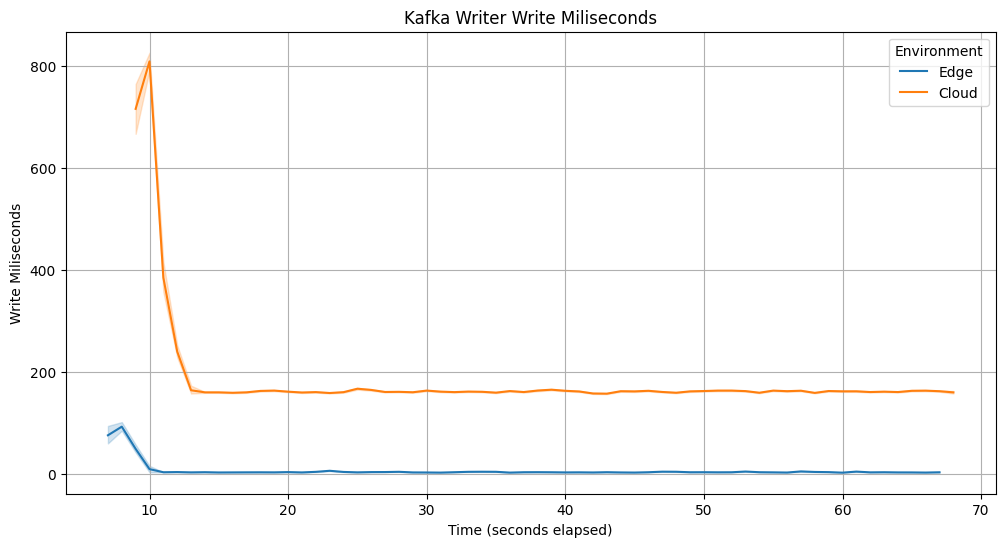

In [21]:
metric_name = 'kafka_writer_write_seconds'

df = df_combined[df_combined['metric_name'] == metric_name]

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='relative_time', y='metric_value', hue='Environment')

plt.title('Kafka Writer Write Miliseconds')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Write Miliseconds')
plt.grid(True)
plt.show()

In [24]:
df.groupby("Environment").agg(
    avg_metric=("metric_value", "mean"),
    max_metric=("metric_value", "max"),
    min_metric=("metric_value", "min"),
    median_metric=("metric_value", "median")
)

,avg_metric,max_metric,min_metric,median_metric
Environment,,,,
Cloud,169.775112,2707.554027,146.337553,156.473885
Edge,5.458027,1250.974681,0.988201,2.127603


## Resource Analysis

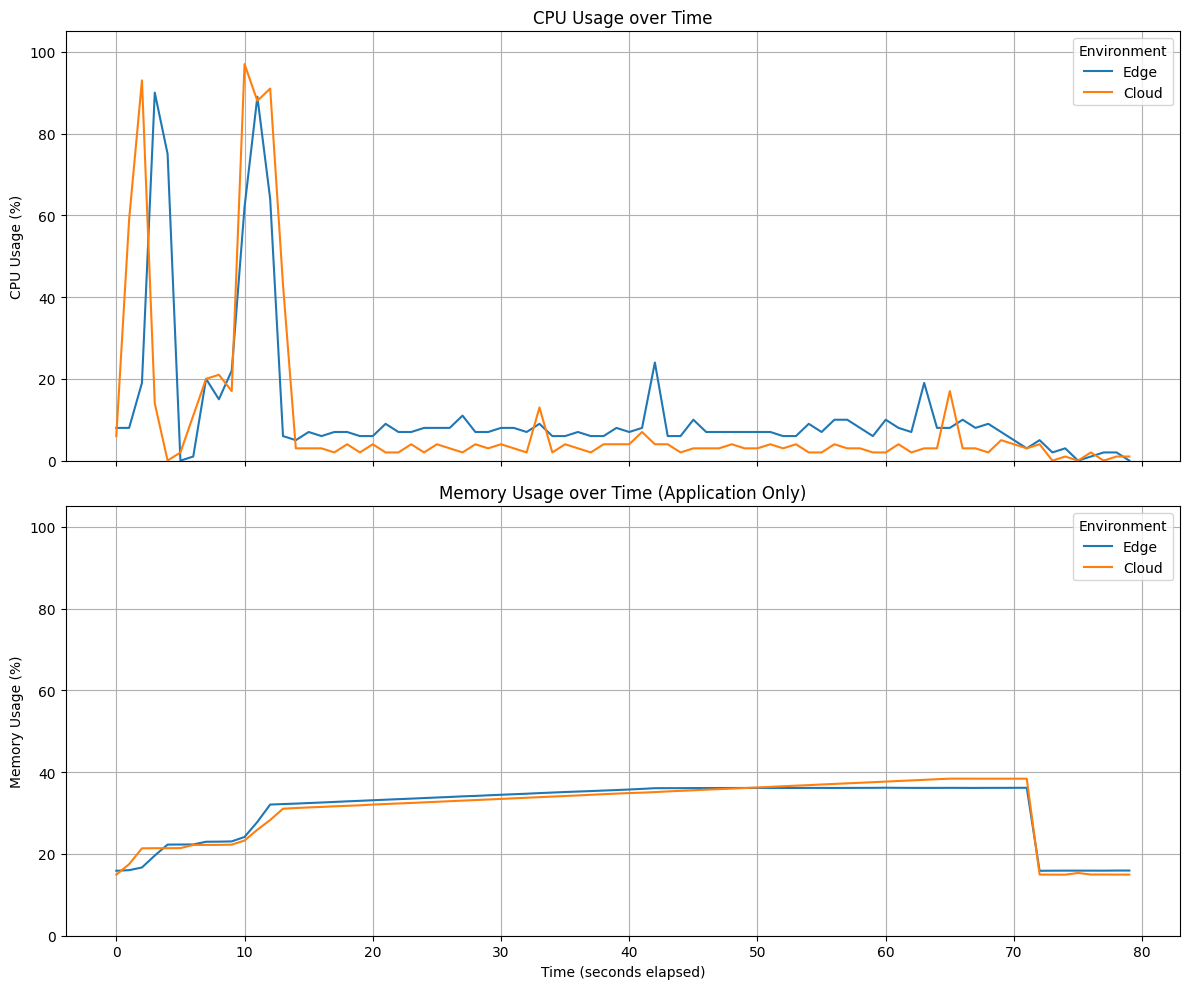

In [49]:
# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Plot CPU
sns.lineplot(data=df_resources, x='relative_time', y='cpu_usage', hue='Environment', ax=axes[0])
axes[0].set_title('CPU Usage over Time')
axes[0].set_ylabel('CPU Usage (%)')
axes[0].grid(True)
axes[0].set_ylim(0, 105) # Cap at 100% for readability

# Plot Memory
sns.lineplot(data=df_resources, x='relative_time', y='mem_usage', hue='Environment', ax=axes[1])
axes[1].set_title('Memory Usage over Time (Application Only)')
axes[1].set_ylabel('Memory Usage (%)')
axes[1].set_xlabel('Time (seconds elapsed)')
axes[1].grid(True)
axes[1].set_ylim(0, 105) # Optional: Un-comment to fix y-axis to 0-100%

plt.tight_layout()
plt.show()

## VUs analysis

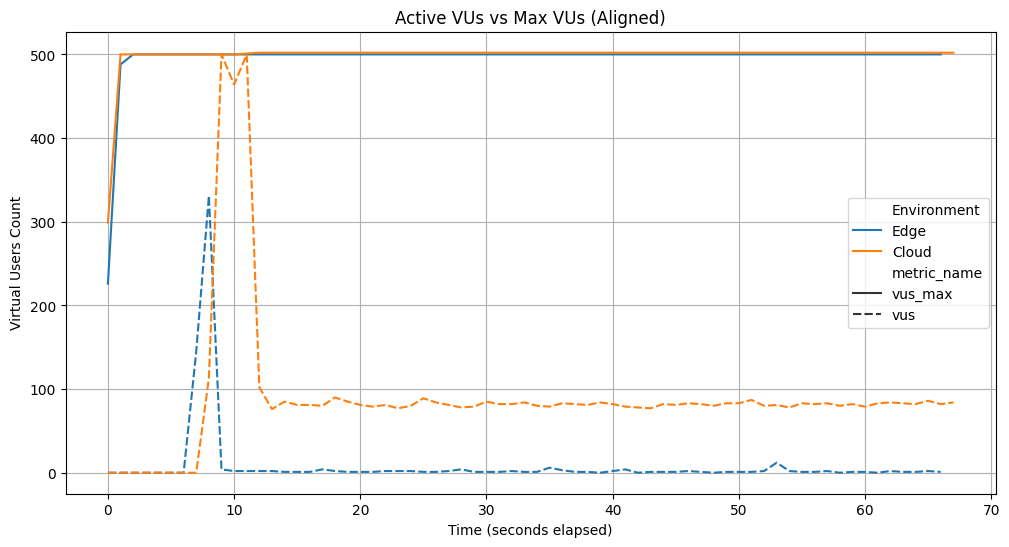

In [25]:
metrics_of_interest = ['vus', 'vus_max']

df = df_combined[df_combined['metric_name'].isin(metrics_of_interest)].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(
    data=df,
    x='relative_time',
    y='metric_value',
    hue='Environment',   # Colors differentiate Edge vs Cloud
    style='metric_name', # Line styles (solid/dashed) differentiate vus vs vus_max
    markers=False,
    dashes=True
)

plt.title('Active VUs vs Max VUs (Aligned)')
plt.xlabel('Time (seconds elapsed)')
plt.ylabel('Virtual Users Count')
plt.grid(True)
plt.show()

# Stress Tests

---

In [ ]:
df_k6_edge = pd.concat([
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-edge/smoke_edge.gz"),
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-edge/rerun/breakpoint_edge.gz"),
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-edge/soak_edge.gz"),
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-edge/rerun/stress_edge.gz")
    ])
df_k6_cloud = pd.concat([
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-cloud/smoke_cloud.gz"),
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-cloud/breakpoint_cloud.gz"),
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-cloud/soak_cloud.gz"),
    pd.read_parquet("../../data/raw/final-01/k6_metrics/final-01-cloud/stress_cloud.gz")
    ])